##

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

## Generating the data



In [12]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Set a seed for reproducibility
np.random.seed(42)

# --- Define parameters for data generation ---
num_events = 200
num_attendees = 1000
start_date = datetime(2022, 1, 1)
end_date = datetime(2024, 12, 31)

event_types = ['Annual Meeting', 'Seminar', 'Workshop', 'Webinar', 'Local Chapter Event']
locations = ['New York', 'Chicago', 'San Francisco', 'Houston', 'Miami', 'Online']
career_stages = ['Student', 'Entry-Level', 'Mid-Career', 'Senior', 'Executive']
credential_status = ['Credentialed', 'Associate', 'Non-Member']

# --- Generate Event Data ---
event_data = []
for i in range(num_events):
    event_id = f'E{i+1:03d}'
    event_date = start_date + timedelta(days=np.random.randint(0, (end_date - start_date).days))
    event_type = np.random.choice(event_types, p=[0.1, 0.2, 0.25, 0.3, 0.15])  # Webinars more frequent
    location = 'Online' if event_type == 'Webinar' else np.random.choice([loc for loc in locations if loc != 'Online'])
    topic = f'Topic {np.random.randint(1, 20)}'  # Simulate different topics
    event_data.append({
        'Event_ID': event_id,
        'Event_Date': event_date,
        'Event_Type': event_type,
        'Location': location,
        'Topic': topic
    })
events_df = pd.DataFrame(event_data)

# --- Generate Attendee Data ---
attendee_data = []
attendee_ids = [f'A{i+1:04d}' for i in range(num_attendees)]
for attendee_id in attendee_ids:
    career_stage = np.random.choice(career_stages, p=[0.15, 0.25, 0.3, 0.2, 0.1])
    geographic_region = np.random.choice(['North East', 'Mid-West', 'South', 'West', 'International'])
    cas_credential_status = np.random.choice(credential_status, p=[0.4, 0.3, 0.3])  # More credentialed members

    attendee_data.append({
        'Attendee_ID': attendee_id,
        'Career_Stage': career_stage,
        'Geographic_Region': geographic_region,
        'CAS_Credential_Status': cas_credential_status
    })
attendees_df = pd.DataFrame(attendee_data)

# --- Generate Attendance Data (linking attendees to events) ---
attendance_data = []
for _ in range(int(num_attendees * 3)):  # Average of 3 events per attendee
    attendee_id = np.random.choice(attendee_ids)
    event_id = np.random.choice(events_df['Event_ID'])

    # Ensure some repeat attendees and first-time attendees
    existing_attendances = [a for a in attendance_data if a['Attendee_ID'] == attendee_id]
    if np.random.rand() < 0.2 and existing_attendances:  # 20% chance of being a repeat attendee
        event_id = np.random.choice([a['Event_ID'] for a in existing_attendances])

    # Get event date for registration date constraint
    event_row = events_df[events_df['Event_ID'] == event_id].iloc[0]
    max_registration_days = (event_row['Event_Date'] - start_date).days - 1
    if max_registration_days > 0:
        registration_date = start_date + timedelta(days=np.random.randint(1, max_registration_days))
    else:
        registration_date = event_row['Event_Date'] - timedelta(days=1)

    attendance_data.append({
        'Attendee_ID': attendee_id,
        'Event_ID': event_id,
        'Registration_Date': registration_date
    })

# Convert to DataFrame and drop duplicates (an attendee can only register once per event)
attendance_df = pd.DataFrame(attendance_data).drop_duplicates(subset=['Attendee_ID', 'Event_ID'])

# --- Merge dataframes to create a comprehensive dataset ---
merged_df = pd.merge(attendance_df, events_df, on='Event_ID', how='left')
merged_df = pd.merge(merged_df, attendees_df, on='Attendee_ID', how='left')

# Add 'First_Time_Attendee' column
merged_df['First_Time_Attendee_Flag'] = False
first_attendance = merged_df.groupby('Attendee_ID')['Event_Date'].min().reset_index()
first_attendance.rename(columns={'Event_Date': 'First_Event_Date'}, inplace=True)
merged_df = pd.merge(merged_df, first_attendance, on='Attendee_ID', how='left')
merged_df['First_Time_Attendee_Flag'] = (merged_df['Event_Date'] == merged_df['First_Event_Date'])
merged_df.drop(columns=['First_Event_Date'], inplace=True)

# Add a 'Member_Status' for explicit member/non-member comparison
merged_df['Member_Status'] = np.where(merged_df['CAS_Credential_Status'] == 'Non-Member', 'Non-Member', 'Member')

# --- Display sample data ---
print("--- Sample Event Data ---")
print(events_df.head())
print("\n--- Sample Attendee Data ---")
print(attendees_df.head())
print("\n--- Sample Merged Attendance Data ---")
print(merged_df.head())

# --- Basic Data Checks (optional, for verification) ---
print(f"\nTotal unique events: {events_df['Event_ID'].nunique()}")
print(f"Total unique attendees: {attendees_df['Attendee_ID'].nunique()}")
print(f"Total attendance records: {len(merged_df)}")
print(f"Attendance by Event Type:\n{merged_df['Event_Type'].value_counts()}")
print(f"Attendance by CAS Credential Status:\n{merged_df['CAS_Credential_Status'].value_counts()}")
print(f"Attendance by Career Stage:\n{merged_df['Career_Stage'].value_counts()}")
print(f"First-time vs. Repeat Attendees (based on records):\n{merged_df['First_Time_Attendee_Flag'].value_counts()}")

# Save to CSV for easy use
events_df.to_csv('sample_events_data.csv', index=False)
attendees_df.to_csv('sample_attendees_data.csv', index=False)
merged_df.to_csv('sample_attendance_merged_data.csv', index=False)

print("\nSample datasets saved as CSV files.")

--- Sample Event Data ---
  Event_ID Event_Date Event_Type       Location     Topic
0     E001 2024-05-10    Seminar          Miami   Topic 7
1     E002 2022-05-02    Seminar  San Francisco  Topic 11
2     E003 2022-03-29   Workshop  San Francisco   Topic 2
3     E004 2022-12-10    Webinar         Online   Topic 6
4     E005 2023-01-21    Seminar          Miami   Topic 1

--- Sample Attendee Data ---
  Attendee_ID Career_Stage Geographic_Region CAS_Credential_Status
0       A0001   Mid-Career        North East             Associate
1       A0002  Entry-Level     International             Associate
2       A0003    Executive     International             Associate
3       A0004      Student          Mid-West             Associate
4       A0005   Mid-Career          Mid-West            Non-Member

--- Sample Merged Attendance Data ---
  Attendee_ID Event_ID Registration_Date Event_Date           Event_Type  \
0       A0834     E036        2022-05-31 2023-08-01              Webinar   
1  

## Event Type Preferences


Event Type Preference:
First_Time_Attendee_Flag  False  True  Repeat_Ratio
Event_Type                                         
Local Chapter Event         250   120      0.675676
Seminar                     302   155      0.660832
Webinar                     464   248      0.651685
Annual Meeting              226   131      0.633053
Workshop                    388   302      0.562319


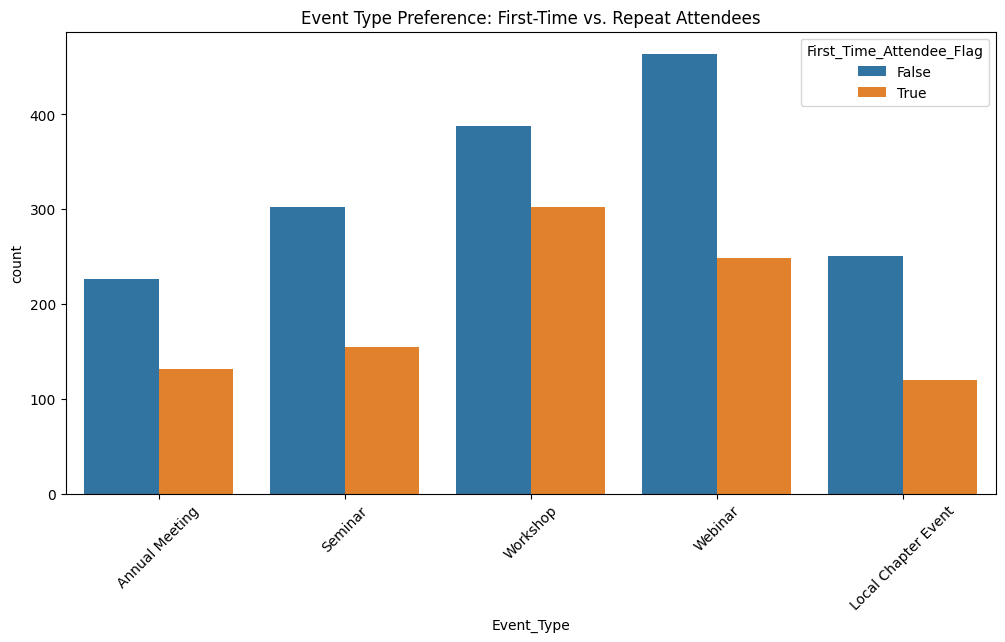

In [13]:
# Which event types attract more first-time vs. repeat attendees?
event_type_summary = merged_df.groupby(['Event_Type', 'First_Time_Attendee_Flag']).size().unstack()
event_type_summary['Repeat_Ratio'] = event_type_summary[False] / (event_type_summary[True] + event_type_summary[False])

print("\nEvent Type Preference:")
print(event_type_summary.sort_values('Repeat_Ratio', ascending=False))

# Visualize
plt.figure(figsize=(12, 6))
sns.countplot(
    data=merged_df,
    x='Event_Type',
    hue='First_Time_Attendee_Flag',
    order=event_types  # From your original list
)
plt.title("Event Type Preference: First-Time vs. Repeat Attendees")
plt.xticks(rotation=45)
plt.show()

## Geographic Trends

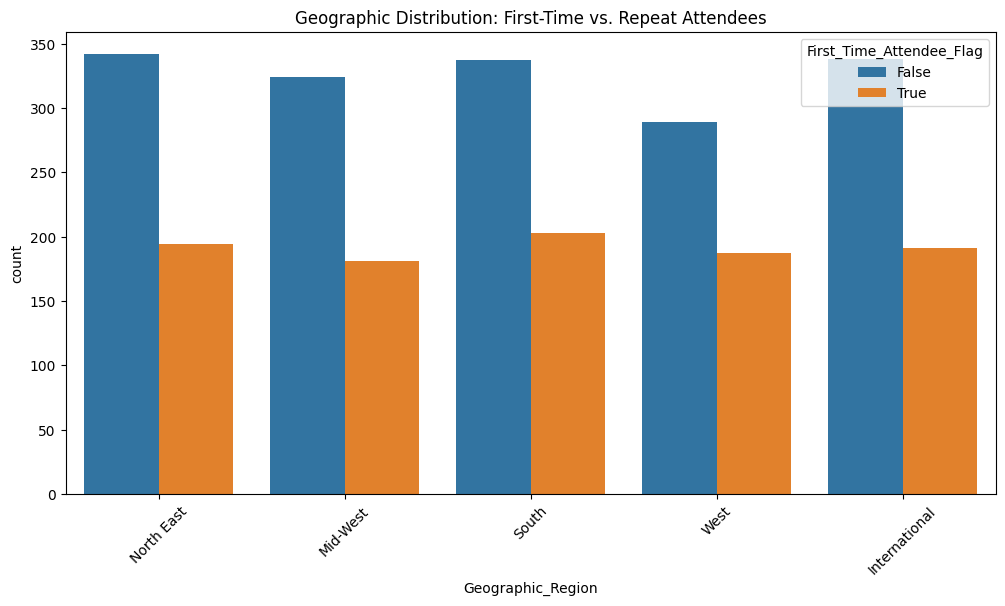

In [14]:
# Geographic distribution comparison
region_order = ['North East', 'Mid-West', 'South', 'West', 'International']
plt.figure(figsize=(12, 6))
sns.countplot(
    data=merged_df,
    x='Geographic_Region',
    hue='First_Time_Attendee_Flag',
    order=region_order
)
plt.title("Geographic Distribution: First-Time vs. Repeat Attendees")
plt.xticks(rotation=45)
plt.show()

## 5. Retention Analysis

In [15]:
# Calculate retention rate (simplified)
repeat_attendees = merged_df[merged_df['First_Time_Attendee_Flag'] == False]['Attendee_ID'].nunique()
total_attendees = merged_df['Attendee_ID'].nunique()
retention_rate = repeat_attendees / total_attendees * 100

print(f"\nRetention Rate: {retention_rate:.1f}% of attendees have attended more than one event.")


Retention Rate: 79.6% of attendees have attended more than one event.
